In [20]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

dataDir = ""

Read the data.  There are three items in the pickle:

- The data (a dict indexed by "fiberId" containing numpy arrays):
 - pixelPos           Measured centroid of an arc line (pixels)
 - pixelPosErr        Error in pixelPos
 - refWavelength      Nominal wavelength (from NIST)
 - modelFitWavelength Wavelength corresponding to pixelPos, based on instrument model
 - status             bitwise OR of flags (see statusFlags)
- A dict giving the meaning of the status bits
- An linear approximation to the wavelength solution:  wavelength = wavelength0 + nmPerPix*i

In [2]:
import pickle

with open(os.path.join(dataDir, "arclines.pickle"), "rb") as fd:
    data, statusFlags, (wavelength0, nmPerPix) = pickle.load(fd)

In [3]:
data

{5: {'modelFitWavelength': array([ 633.61816406,  638.47613525,  640.40216064,  650.83178711,
          653.4697876 ,  660.07843018,  665.39117432,  668.01098633,
          671.88812256,  693.12994385,  621.67956543,  706.10821533,
          717.59020996,  724.71917725,  744.09533691,  747.44799805,
          749.09210205,  753.78485107,  754.6105957 ,  794.53619385,
          808.46337891,  812.07446289,  813.86047363,  826.15899658,
          826.84509277,  830.26525879,  836.80072021,  846.56335449,
          848.68334961,  849.76519775,  854.70074463,  857.37554932,
          859.35858154,  863.70043945,  864.94726562,  865.67962646,
          870.6519165 ,  877.40405273,  885.63024902,  886.81420898,
          892.19763184,  899.10797119,  915.1192627 ,  920.42938232,
          927.81976318,  930.33990479,  932.90112305,  937.5814209 ,
          942.79974365,  946.17974854,  948.92419434,  953.67156982,
          954.99707031,  966.80291748]),
  'pixelPos': array([  137.5663147 , 

Plot some of the data.  A good place to start would be the pixel position (pixelPos) and the reference wavelength (refWavelength) for a fibre, then use wavelength0 and nmPerPix to construct an approximate (linear) wavelength solution and look at the residuals.

<IPython.core.display.Javascript object>


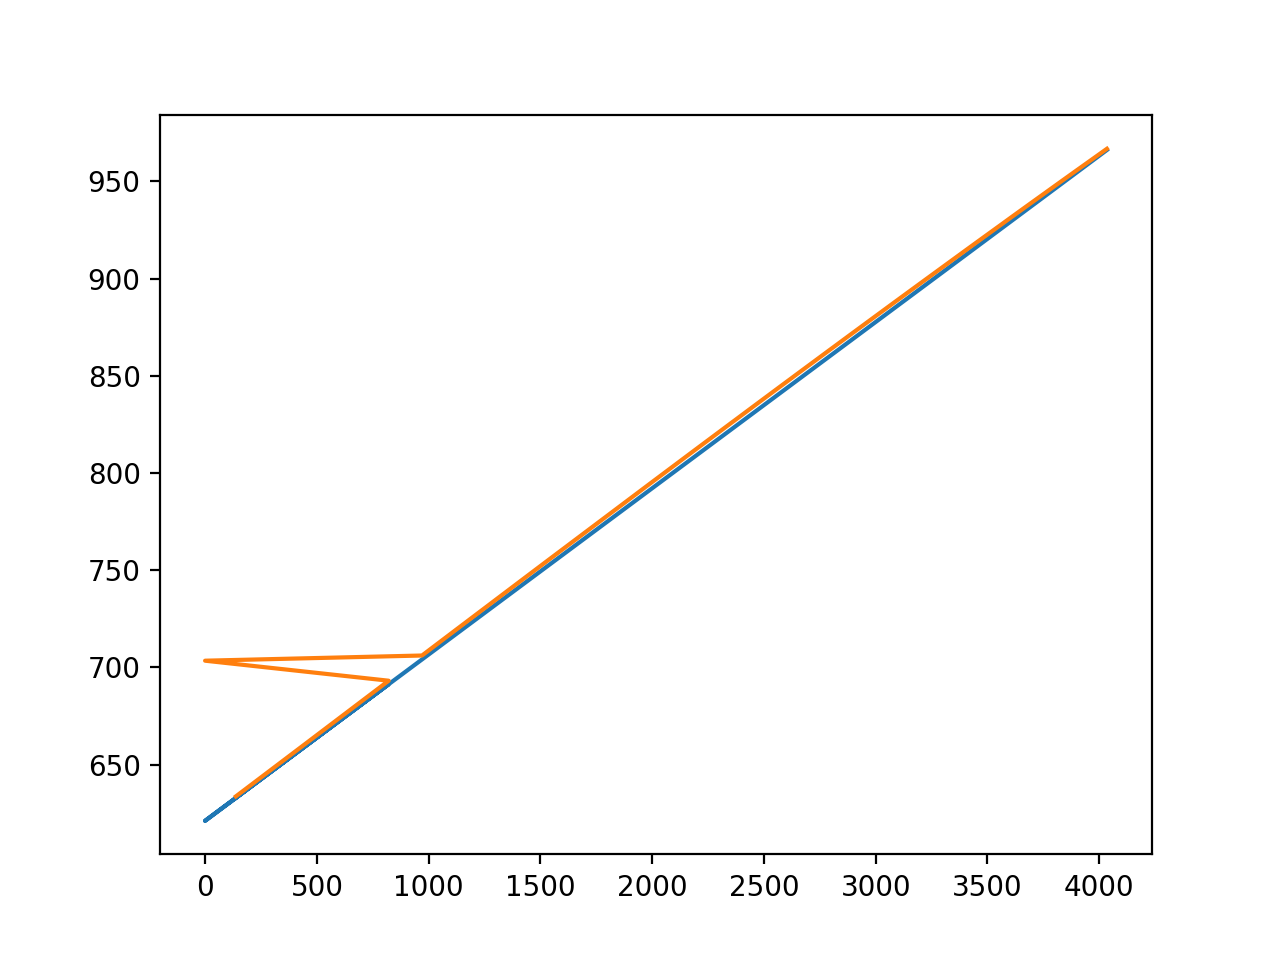

In [18]:
fiberId = 5 # the fiber id from the dictionary name, not the 5th element
assert fiberId in data, "Unknown fiberId: %d" % fiberId
pixelPos = data[5]['pixelPos']
refWavelength = data[5]['refWavelength']

wavelength_approx = wavelength0 + nmPerPix*pixelPos #linear approximation of the wavelength solution from the pixel pos

plt.plot(pixelPos, wavelength_approx)
plt.plot(pixelPos, refWavelength)

Take a look at the statusFlags and the values of status from your fibre.  You probably want to ignore some of the data (Hint: I muttered about bad lines in the lecture)

{'FIT': 1, 'RESERVED': 2, 'SATURATED': 16, 'CR': 64, 'MISIDENTIFIED': 4, 'CLIPPED': 8}
[  1   1   1   1   1   1   1   1   1  49 112   1   1  49   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1]
54
[ True  True  True  True  True  True  True  True  True False False  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


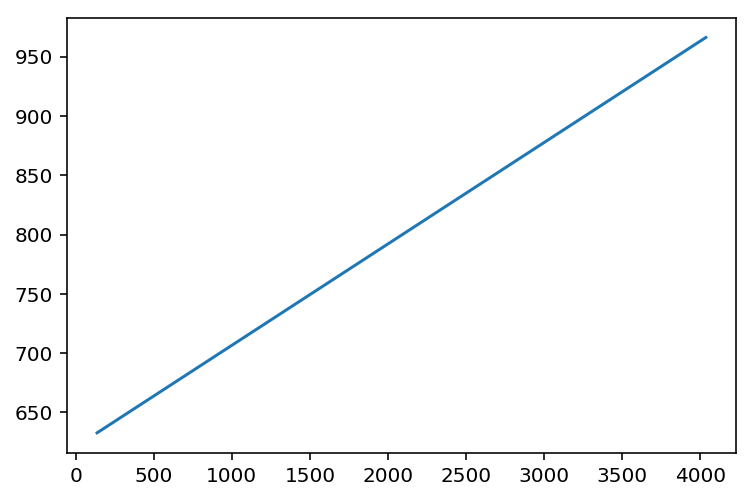

In [22]:
print(statusFlags)
print(data[5]['status'])
print(len(data[5]['pixelPos'])) # have 54 pixels and this is the status for each pixel
statusFlags.keys() #Cr= cosmic ray 'Interpolated":32 => 49 is fit, interpolated , and staturated
good_data = (data[5]['status']==1)
print(good_data)

plt.plot(pixelPos[good_data], wavelength_approx[good_data]) #plot the good data with the linear wavelenght approx

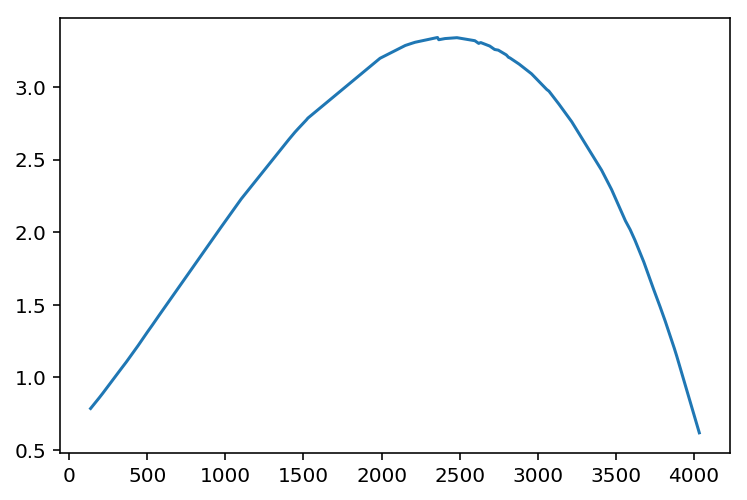

In [23]:
plt.plot(pixelPos[good_data], refWavelength[good_data]-wavelength_approx[good_data]) #residules

Let's concentrate on just one fiber for now; choose a fibre, any fibre.  We want to fit a better model of the wavelength solution.  The CCD has 4096 rows, and we want a solution valid over all of them.

Experiment with a range of order of fitter, and look at the rms error in the wavelength solution.  You can look at $\chi^2/\nu$ too, if you like, but I think you'll find that the centroiding errors are wrong.

You probably want to look at the fit and at the residuals from the fit.

[  6.21102875e+02   8.85501180e-02  -3.43323642e-07]


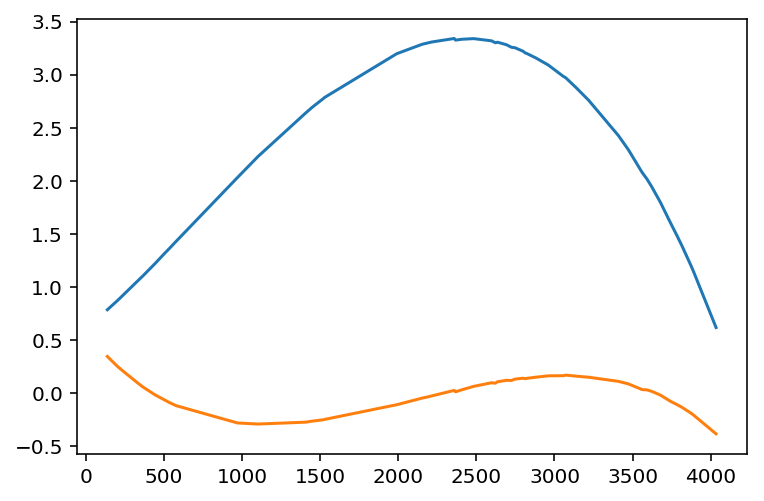

In [33]:
import numpy.polynomial.chebyshev
myFiberId = 5

nrow = 4096
fitOrder = 2

pixelPos_g = pixelPos[good_data]  
refWavelength_g = refWavelength[good_data]

# do the chebby on the good data
cheb_coeffs = numpy.polynomial.chebyshev.chebfit(pixelPos_g, refWavelength_g, fitOrder)
print(cheb_coeffs)

cheb_fit = numpy.polynomial.chebyshev.chebval(pixelPos_g, cheb_coeffs)

plt.plot(pixelPos_g, refWavelength_g - wavelength_approx[good_data])
plt.plot(pixelPos_g, refWavelength_g - cheb_fit)

Now repeat the preceeding exercise using the model of the spectrograph (i.e. the modelFitWavelength not your linear approximation).  What order of polynomial is needed now?

Is that rms error honest, or are we overfitting?  Modify your code to hold back some number of arclines from the fit and measure the rms only of those ones.

If this was all

I was nice and gave you clean (but real) data.  In the real world you'd probably want to do an n-sigma clip on the residuals and iterate.  Implement this.